In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

from keras.models import Sequential 
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import categorical_accuracy
from keras.callbacks import Callback
from keras.utils import model_to_dot, plot_model

In [2]:
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [3]:
# function to create images, takes a df, height and width and returns an array of h x w images for each row in the df
def reshape_as_image(x, h, w):
    x_temp = np.zeros( (len(x), h, w))
    for i in range(len(x)):
        x_temp[i] = np.reshape(x[i], (h, w))
    return x_temp

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.options.mode.use_inf_as_na = True

# CNN to identify BUY and SELL signals for Bitcoin
## Part 1: Load data, create X features and y targets, 80/20 train/test split

In [5]:
# load first 10,000 rows of selected batch, make sure to drop NaN and reset index
batch_num = 1
df = pd.read_csv(f"./indicator_batches/batch_{str(batch_num)}_indicators", index_col=0, nrows=10000)
df.dropna(inplace=True)
df = df.reset_index(drop=True)

# print out the first 5 rows
df.head()

,time,open,close,high,low,volume,label,SMA_6,SMA_7,SMA_8,SMA_9,SMA_10,SMA_11,SMA_12,SMA_13,SMA_14,SMA_15,SMA_16,SMA_17,SMA_18,EMA_6,EMA_7,EMA_8,EMA_9,EMA_10,EMA_11,EMA_12,EMA_13,EMA_14,EMA_15,EMA_16,EMA_17,EMA_18,WMA_6,WMA_7,WMA_8,WMA_9,WMA_10,WMA_11,WMA_12,WMA_13,WMA_14,WMA_15,WMA_16,WMA_17,WMA_18,HMA_6,HMA_7,HMA_8,HMA_9,HMA_10,HMA_11,HMA_12,HMA_13,HMA_14,HMA_15,HMA_16,HMA_17,HMA_18,TEMA_6,TEMA_7,TEMA_8,TEMA_9,TEMA_10,TEMA_11,TEMA_12,TEMA_13,TEMA_14,TEMA_15,TEMA_16,TEMA_17,TEMA_18,RSI_6,RSI_7,RSI_8,RSI_9,RSI_10,RSI_11,RSI_12,RSI_13,RSI_14,RSI_15,RSI_16,RSI_17,RSI_18,williamsR_6,williamsR_7,williamsR_8,williamsR_9,williamsR_10,williamsR_11,williamsR_12,williamsR_13,williamsR_14,williamsR_15,williamsR_16,williamsR_17,williamsR_18,CCI_6,CCI_7,CCI_8,CCI_9,CCI_10,CCI_11,CCI_12,CCI_13,CCI_14,CCI_15,CCI_16,CCI_17,CCI_18,CMO_6,CMO_7,CMO_8,CMO_9,CMO_10,CMO_11,CMO_12,CMO_13,CMO_14,CMO_15,CMO_16,CMO_17,CMO_18,MACD_dif_6,MACD_dif_7,MACD_dif_8,MACD_dif_9,MACD_dif_10,MACD_dif_11,MACD_dif_12,MACD_dif_13,MACD_dif_14,MACD_dif_15,MACD_dif_16,MACD_dif_17,MACD_dif_18,PPO_dif_6,PPO_dif_7,PPO_dif_8,PPO_dif_9,PPO_dif_10,PPO_dif_11,PPO_dif_12,PPO_dif_13,PPO_dif_14,PPO_dif_15,PPO_dif_16,PPO_dif_17,PPO_dif_18,ROC_6,ROC_7,ROC_8,ROC_9,ROC_10,ROC_11,ROC_12,ROC_13,ROC_14,ROC_15,ROC_16,ROC_17,ROC_18,stoch_os_6,stoch_os_7,stoch_os_8,stoch_os_9,stoch_os_10,stoch_os_11,stoch_os_12,stoch_os_13,stoch_os_14,stoch_os_15,stoch_os_16,stoch_os_17,stoch_os_18
0,2014-01-01 09:00:00,744.97,744.97,744.97,744.97,0.038462,0.0,748.063333,748.340000,748.23750,747.863333,747.494,747.197282,746.945008,746.756931,746.595721,746.478673,746.378131,746.289418,746.345561,747.081871,747.136976,747.149938,747.138432,747.113336,747.081250,747.046124,747.010290,746.975088,746.941257,746.909172,746.878988,746.850729,747.330952,747.583214,747.728611,747.755556,747.708000,747.622880,747.518592,747.409784,747.301242,747.198421,747.101916,747.011639,746.941525,745.497937,745.308929,746.234278,747.056481,747.739009,747.877558,748.404023,748.541821,748.896662,749.016456,749.325780,749.420476,749.277978,745.796062,746.209924,746.575721,746.878408,747.117131,747.297830,747.428966,747.519311,747.576919,747.608744,747.620582,747.617153,747.602247,8.566722,35.087719,50.446429,53.361345,53.093202,53.327732,51.902803,51.902803,50.512206,50.393076,50.393076,42.310333,49.914041,-97.509579,-97.509579,-97.509579,-97.509579,-81.701445,-81.701445,-81.701445,-81.701445,-81.701445,-81.701445,-81.701445,-81.701445,-81.701445,-94.856314,-106.875510,-111.361489,-89.821263,-70.882571,-59.523092,-51.805238,-47.094518,-42.680990,-40.396411,-38.454634,-36.762925,-39.337607,-82.866557,-29.824561,0.892857,6.722689,6.186403,6.655463,3.805606,3.805606,1.024413,0.786151,0.786151,-15.379335,-0.171918,0.307942,0.301877,0.291322,0.278533,0.264857,0.251089,0.237680,0.224877,0.212798,0.201490,0.190951,0.181156,0.172066,0.041256,0.040444,0.039031,0.037318,0.035487,0.033642,0.031846,0.030130,0.028512,0.026996,0.025584,0.024271,0.023053,-0.535395,-0.670667,-0.341128,0.013425,0.107502,0.099418,0.107502,0.063130,0.063130,0.017453,0.013425,0.013425,-0.311789,46.591326,50.998414,52.173215,54.401600,53.890461,53.427234,52.219381,56.216568,77.959358,79.153572,72.044327,77.272457,77.960276
1,2014-01-01 09:01:00,744.84,744.84,744.84,744.84,0.009309,0.0,747.373333,747.602857,747.90250,747.860000,747.561,747.252727,747.000842,746.783085,746.620007,746.478673,746.376256,746.287653,746.208894,746.440945,746.561706,746.634572,746.675328,746.694941,746.700817,746.697895,746.689448,746.677641,746.663904,746.649179,746.634083,746.619017,746.410000,746.708214,746.973611,747.150889,747.225455,747.230000,747.194745,747.135936,747.067146,746.993587,746.920960,746.850592,746.783045,744.066349,743.783452,744.603389,745.118296,745.934141,745.988822,746.709091,746.800852,747.382504,747.475323,748.294227,748.378767,748.504726,744.824611,745.147609,745.477981,745.783317,746.048916,746.270758,746.450535,746.592590,746.702176,746.784552,746.844540,746.8

In [6]:
# print out the shape of the dataframe after NaNs are dropped
df.shape

(9970, 176)

In [7]:
# look at the precentage of each class (Buy, Sell, and Hold)
df['label'].value_counts(normalize=True)*100

0.0    91.203611
2.0     4.623872
1.0     4.172518
Name: label, dtype: float64

In [8]:
# Create X features and y target, X = all technical indicators, y = labels, timestamp, price and volume dropped
X, y = df.iloc[:, 7:], df.iloc[:, 6]
X.shape, y.shape

((9970, 169), (9970,))

In [9]:
# create a seperate X features and y target using SMOTE to over-sample the minority classes
smote = SMOTE(sampling_strategy={0: 9093, 1: 4500, 2: 4500}, random_state=42, n_jobs=-1)
X_smote, y_smote = smote.fit_resample(X, y)
X_smote.shape, y_smote.shape

((18093, 169), (18093,))

In [10]:
# look at the percentage of each class after over-sampling 
y_smote.value_counts(normalize=True)*100

0.0    50.257005
1.0    24.871497
2.0    24.871497
Name: label, dtype: float64

In [11]:
# scale X features between 0,1 
min_max = MinMaxScaler()
X = min_max.fit_transform(X)

In [12]:
# Split the original highly imbalanced dataset into 80/20 train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7976, 169), (1994, 169), (7976,), (1994,))

In [13]:
one_hot = OneHotEncoder(sparse=False, categories='auto')
y_train = one_hot.fit_transform(np.array(y_train).reshape(-1,1))
y_test = one_hot.fit_transform(np.array(y_test).reshape(-1,1))
y_train.shape, y_test.shape

((7976, 3), (1994, 3))

In [14]:
dim = 13
X_train = reshape_as_image(X_train, dim, dim)
X_test = reshape_as_image(X_test, dim, dim)

# adding a 1-dim for channels (3)
X_train = np.stack((X_train,)*3, axis=-1)
X_test = np.stack((X_test,)*3, axis=-1)

X_train.shape, X_test.shape

((7976, 13, 13, 3), (1994, 13, 13, 3))

## Part 2: Build, Train, and Test a CNN using Keras

In [15]:
input_shape = X_train[0].shape[0], X_train[0].shape[1], X_train[0].shape[2]

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [17]:
model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.01), metrics=['accuracy'])

In [18]:
history = AccuracyHistory()

In [19]:
history = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=300,
    verbose=0,
    validation_data= (X_test, y_test),
    callbacks=[history]
)

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.24177967699444522
Test accuracy:  0.9112337231636047


In [21]:
# convert y_test back into an index from the one_hot_encoding needed for CNN
y_class_true = np.argmax(y_test, axis=1)

# use CNN to predict 
y_pred = model.predict_classes(X_test)
y_pred.shape

(1994,)

In [22]:
# look at number of predicted classes -> looks like the model is classifying almost every observation as Hold
pd.Series(y_pred).value_counts()

0    1994
dtype: int64

In [23]:
# create a confusion matrix
cf_matrix = confusion_matrix(y_class_true, y_pred)

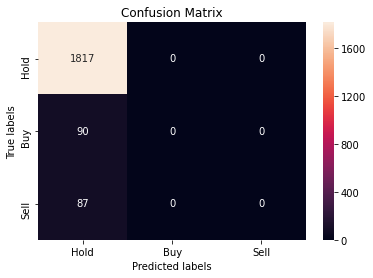

In [24]:
# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Hold', 'Buy', 'Sell'])
ax.yaxis.set_ticklabels(['Hold', 'Buy', 'Sell']);

In [53]:
f1_macro = f1_score(y_class_true, y_pred, average='macro')
precision_macro = precision_score(y_class_true, y_pred, average='macro')
recall_macro = recall_score(y_class_true, y_pred, average='macro')
acc = accuracy_score(y_class_true, y_pred)

In [52]:
precision, recall, f1, support = precision_recall_fscore_support(y_class_true, y_pred)

In [54]:
print('Macro Metrics')
print('====='*10)
print(f'Accuracy: {round(acc,4)}')
print(f'Precision: {round(precision_macro, 4)}')
print(f'Recall: {round(recall_macro, 4)}')
print(f'F1 Score: {round(f1_macro, 4)}')
print('====='*10)

Macro Metrics
Accuracy: 0.9112
Precision: 0.3037
Recall: 0.3333
F1 Score: 0.3179


In [28]:
metrics = pd.DataFrame(['Hold', 'Buy', 'Sell'], columns=['label'])
metrics['precision'] = pd.Series(precision.reshape(-1))
metrics['recall'] = pd.Series(recall.reshape(-1))
metrics['f1_score'] = pd.Series(f1.reshape(-1))
metrics['true_values'] = pd.Series(support.reshape(-1))
metrics['predicted_values'] = pd.Series(y_pred).value_counts()

In [29]:
metrics.set_index('label')

,precision,recall,f1_score,true_values,predicted_values
label,,,,,
Hold,0.911234,1.0,0.953555,1817,1994.0
Buy,0.000000,0.0,0.000000,90,NaN
Sell,0.000000,0.0,0.000000,87,NaN


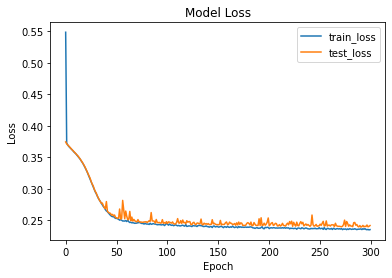

In [30]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

## Part 3: Model using SMOTE data to fix class imbalance

In [31]:
# look at shape of SMOTE dataset
X_smote.shape, y_smote.shape

((18093, 169), (18093,))

In [32]:
# look at the percentage of each class after over-sampling 
y_smote.value_counts(normalize=True)*100

0.0    50.257005
1.0    24.871497
2.0    24.871497
Name: label, dtype: float64

In [33]:
# scale X features between 0,1 
min_max = MinMaxScaler()
X_smote = min_max.fit_transform(X_smote)

In [34]:
# Split the original highly imbalanced dataset into 80/20 train/test sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
X_train_smote.shape, X_test_smote.shape, y_train_smote.shape, y_test_smote.shape

((14474, 169), (3619, 169), (14474,), (3619,))

In [35]:
one_hot = OneHotEncoder(sparse=False, categories='auto')
y_train_smote = one_hot.fit_transform(np.array(y_train_smote).reshape(-1,1))
y_test_smote = one_hot.fit_transform(np.array(y_test_smote).reshape(-1,1))
y_train_smote.shape, y_test_smote.shape

((14474, 3), (3619, 3))

In [36]:
dim = 13
X_train_smote = reshape_as_image(X_train_smote, dim, dim)
X_test_smote = reshape_as_image(X_test_smote, dim, dim)

# adding a 1-dim for channels (3)
X_train_smote = np.stack((X_train_smote,)*3, axis=-1)
X_test_smote = np.stack((X_test_smote,)*3, axis=-1)

X_train_smote.shape, X_test_smote.shape

((14474, 13, 13, 3), (3619, 13, 13, 3))

In [37]:
input_shape = X_train_smote[0].shape[0], X_train_smote[0].shape[1], X_train_smote[0].shape[2]

model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.05), metrics=['categorical_accuracy'])

class_weights = {
    0: 1,
    1: 5,
    2: 10
}

smote_history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=300,
    shuffle=True,
    verbose=2,
    validation_data= (X_test_smote, y_test_smote),
    class_weight=class_weights,
    callbacks=[history]
)

Train on 7976 samples, validate on 3619 samples
Epoch 1/300
 - 1s - loss: 1.2927 - categorical_accuracy: 0.8218 - val_loss: 0.7237 - val_categorical_accuracy: 0.5336
Epoch 2/300
 - 1s - loss: 1.0430 - categorical_accuracy: 0.7588 - val_loss: 0.7326 - val_categorical_accuracy: 0.6518
Epoch 3/300
 - 1s - loss: 0.9937 - categorical_accuracy: 0.7322 - val_loss: 0.6308 - val_categorical_accuracy: 0.5587
Epoch 4/300
 - 1s - loss: 0.9478 - categorical_accuracy: 0.7352 - val_loss: 0.5543 - val_categorical_accuracy: 0.7375
Epoch 5/300
 - 1s - loss: 0.9465 - categorical_accuracy: 0.7281 - val_loss: 0.6150 - val_categorical_accuracy: 0.6560
Epoch 6/300
 - 1s - loss: 0.8873 - categorical_accuracy: 0.7205 - val_loss: 0.6525 - val_categorical_accuracy: 0.5637
Epoch 7/300
 - 1s - loss: 0.8713 - categorical_accuracy: 0.7293 - val_loss: 0.9012 - val_categorical_accuracy: 0.5551
Epoch 8/300
 - 1s - loss: 0.8721 - categorical_accuracy: 0.7333 - val_loss: 0.6982 - val_categorical_accuracy: 0.5872
Epoch 9/

In [55]:
score = model.evaluate(X_test_smote, y_test_smote, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.6675106179845138
Test accuracy:  0.8311688303947449


In [56]:
# convert y_test back into an index from the one_hot_encoding needed for CNN
y_true_smote = np.argmax(y_test_smote, axis=1)

# use CNN to predict 
y_pred_smote = model.predict_classes(X_test_smote)
y_pred_smote.shape

(3619,)

In [58]:
# look at number of predicted classes -> looks like the model is classifying almost every observation as Hold
pd.Series(y_pred_smote).value_counts()

0    2261
1     731
2     627
dtype: int64

In [59]:
pd.Series(y_true_smote).value_counts()

0    1848
1     893
2     878
dtype: int64

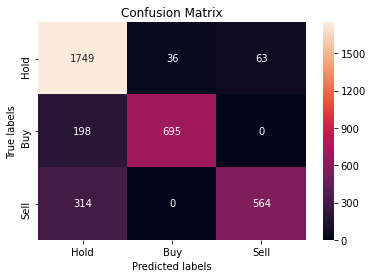

In [60]:
# create a confusion matrix
cf_matrix = confusion_matrix(y_true_smote, y_pred_smote)

# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Hold', 'Buy', 'Sell'])
ax.yaxis.set_ticklabels(['Hold', 'Buy', 'Sell']);

In [61]:
f1_macro_smote = f1_score(y_true_smote, y_pred_smote, average='macro')
precision_macro_smote = precision_score(y_true_smote, y_pred_smote, average='macro')
recall_macro_smote = recall_score(y_true_smote, y_pred_smote, average='macro')
acc_smote = accuracy_score(y_true_smote, y_pred_smote)

In [62]:
precision_smote, recall_smote, f1_smote, support_smote = precision_recall_fscore_support(y_true_smote, y_pred_smote)

In [63]:
print('Macro Metrics SMOTE')
print('====='*5)
print(f'Accuracy: {round(acc_smote,4)}')
print(f'Precision: {round(precision_macro_smote, 4)}')
print(f'Recall: {round(recall_macro_smote, 4)}')
print(f'F1 Score: {round(f1_macro_smote, 4)}')
print('====='*5)

Macro Metrics SMOTE
Accuracy: 0.8312
Precision: 0.8746
Recall: 0.789
F1 Score: 0.8189


In [64]:
metrics_smote = pd.DataFrame(['Hold', 'Buy', 'Sell'], columns=['label'])
metrics_smote['precision'] = pd.Series(precision_smote.reshape(-1))
metrics_smote['recall'] = pd.Series(recall_smote.reshape(-1))
metrics_smote['f1_score'] = pd.Series(f1_smote.reshape(-1))
metrics_smote['true_values'] = pd.Series(support_smote.reshape(-1))
metrics_smote['predicted_values'] = pd.Series(y_pred_smote).value_counts()

metrics_smote.set_index('label')

,precision,recall,f1_score,true_values,predicted_values
label,,,,,
Hold,0.773552,0.946429,0.851302,1848,2261
Buy,0.950752,0.778275,0.855911,893,731
Sell,0.899522,0.642369,0.749502,878,627


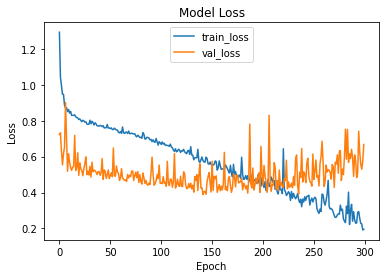

In [65]:
plt.figure()
plt.plot(smote_history.history['loss'])
plt.plot(smote_history.history['val_loss'])
#plt.plot(smote_history.history['categorical_accuracy'])
#plt.plot(smote_history.history['val_categorical_accuracy'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper center') #, 'train_acc', 'test_acc'], loc='upper right')
plt.show()

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)